In [1]:
import tensorflow as tf

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [3]:
import numpy as np
import os
import sys
import func
import fnmatch
import time
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import tikzplotlib
from skimage import io
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from params import dresden_images_root, train_csv_path, patch_span, \
        patch_num, patches_root, patches_db_path

In [4]:
# Define image and batch size
img_height = 256
img_width = 256
batch_size = 64

# Load and Compile the model
model = tf.keras.models.load_model('model.h5')

sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.95, decay=0.0004)

model.compile(
    optimizer=sgd, 
    loss='binary_crossentropy', 
    metrics=['accuracy'])

# Create the Generator
test_data_gen = ImageDataGenerator(preprocessing_function=None,
    rescale=1./255)

# Read the positive test samples.
test_generator = test_data_gen.flow_from_directory(
                  directory = r"./train/test/",
                  target_size=(img_width, img_height), color_mode='grayscale', shuffle=True,
                  batch_size=batch_size, class_mode="categorical")

# print('\n# Evaluate on test data')
# results = model.evaluate(test_generator)
# print('test loss, test acc:', results)

Found 11775 images belonging to 3 classes.



It tooks 137 seconds

columns are predictions, index are ground truth



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,1424,0,0
Nikon D200,3,1917,7
Olympus mju-1050SW,0,0,3049


The mean of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.999477,0.000000,0.000000
Nikon D200,0.922565,0.998503,0.729212
Olympus mju-1050SW,0.000000,0.000000,0.998871


The standard deviation of the confidence is: 



,Canon Ixus70,Nikon D200,Olympus mju-1050SW
Canon Ixus70,0.000106,0.000000,0.000000
Nikon D200,0.010406,0.000261,0.019516
Olympus mju-1050SW,0.000000,0.000000,0.000234


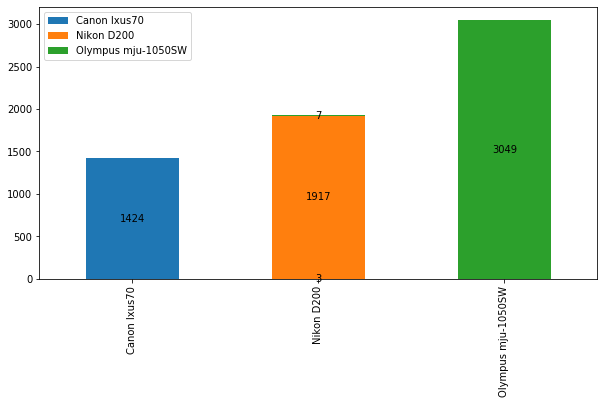

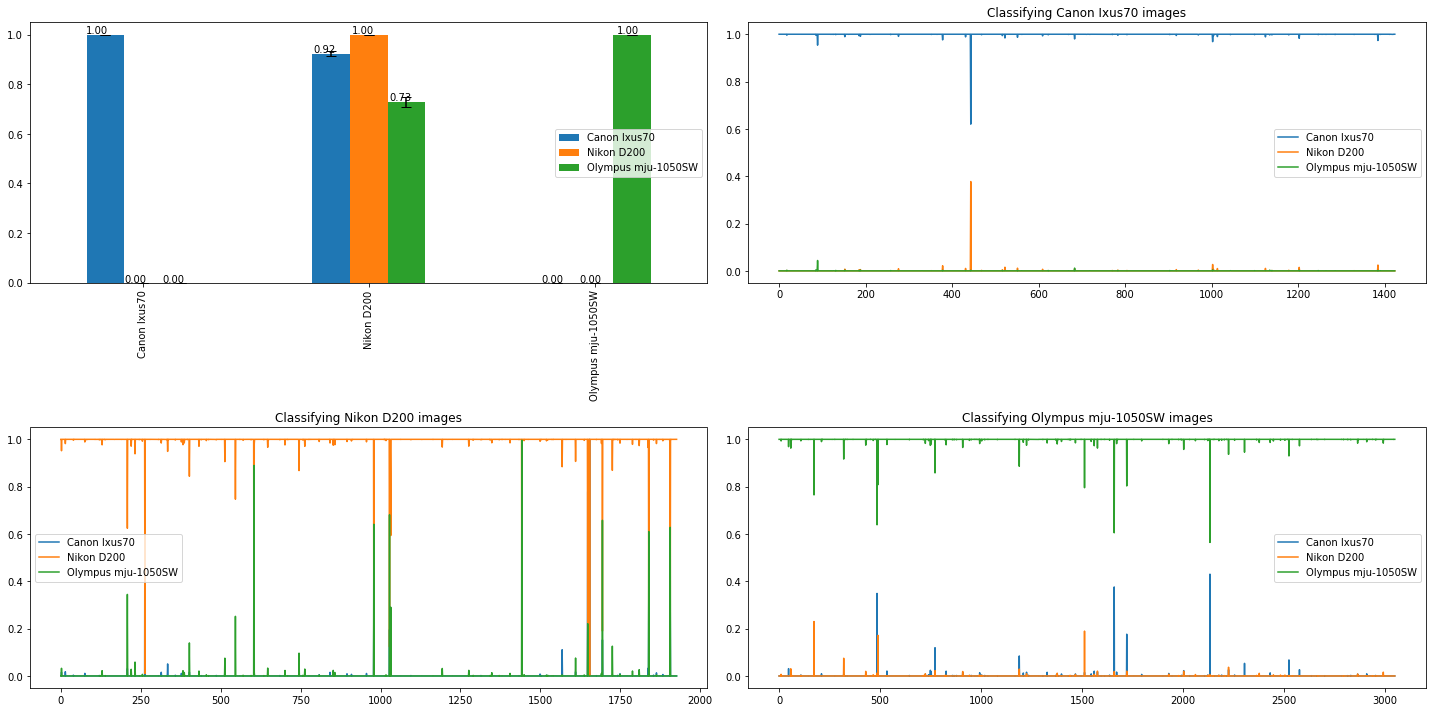

In [5]:
train_db = pd.read_csv(train_csv_path)
model_list = np.unique(train_db['brand_model'])
model_list = [m.replace("_", " ") for m in model_list]

# generate a histogram, which for every unseen models, how many imgs are classified.
hist, conf, pred_labels, real_labels = func.evaluate(model_list, test_generator, model, index=model_list, columns=model_list, title=None, num_batch=100, tex=False)

df_mean, df_error = func.mean_error(conf, pred_labels, real_labels,
                                    real_model=model_list, pred_model=model_list)

# If output tex format, then tex = True
tex = False
if tex:
    ax = df_mean.plot.bar(yerr=df_error, capsize=5, figsize=(10, 6))
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    tikzplotlib.save("test_conf.tex")
    plt.tight_layout()
else:
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
    ax = df_mean.plot.bar(yerr=df_error, capsize=5, ax=axes[0, 0])
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.2f}", (p.get_x() * 1.008, p.get_height() * 1.008))
    graph = {0:axes[0,1], 1:axes[1,0], 2:axes[1, 1]}
    func.plot_conf(conf, pred_labels, real_labels, graph, real_model=model_list, pred_model=model_list)
    plt.tight_layout()